# Full Audio-Visual Classification Model 

This notebook fits the audio-visual classification model. Note that it is dependent on having the audio and visual models already saved to file. 

In [1]:
# Loading Packages
import librosa
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import os
from glob import glob
import scipy.signal as signal
from IPython.display import Audio
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from john_romero_audio_functions import *
from john_romero_video_functions import *

In [2]:
# Loading the Respective Metadata
aud_metadata = get_metadata(mode='r', type='Audio')
vis_metadata = get_metadata(mode='r', type='Video')

In [3]:
### Loading Visual Features 
# Per Partition
train = get_landmark_dataset('train')
val = get_landmark_dataset('val')
test = get_landmark_dataset('test')

# Extracting Partition-Level information
vis_train_fn, train_tar, vis_train_feats = zip(*train)
vis_val_fn, val_tar, vis_val_feats = zip(*val)
vis_test_fn, test_tar, vis_test_feats = zip(*test)

# Normalizing the Visual data 
vis_train_norm = normalize_landmark_ds(vis_train_feats)
vis_val_norm = normalize_landmark_ds(vis_val_feats)
vis_test_norm = normalize_landmark_ds(vis_test_feats)

In [4]:
# Loading the Audio Features and matchingt them in index to their visual counterpart
full_aud_feats = []
for part in [vis_train_fn, vis_val_fn, vis_test_fn]: 
    full_aud_feats.append([aud_data_from_vis_fn(fn, aud_metadata) for fn in list(part)])
aud_train_feats, aud_val_feats, aud_test_feats = full_aud_feats

In [5]:
# Flattening the list of audio features to find the length of the longest file for padding
full_aud_feats_flat = [val for sublist in full_aud_feats for val in sublist]
maxlen = np.max([f.shape[0] for f in full_aud_feats_flat])

# Padding the arrays to the same length
aud_train_feats = np.stack([np.pad(f, pad_width = ((maxlen-f.shape[0], 0), (0, 0))) for f in aud_train_feats])
aud_val_feats = np.stack([np.pad(f, pad_width = ((maxlen-f.shape[0], 0), (0, 0))) for f in aud_val_feats])
aud_test_feats = np.stack([np.pad(f, pad_width = ((maxlen-f.shape[0], 0),(0, 0))) for f in aud_test_feats])

In [6]:
# Stacking the Features and Targets into their respective Tensors
train_tar_oh, vis_train_feats, aud_train_feats = tf.stack(train_tar), tf.ragged.stack(vis_train_norm), tf.stack(aud_train_feats)
val_tar_oh, vis_val_feats, aud_val_feats       = tf.stack(val_tar), tf.ragged.stack(vis_val_norm), tf.stack(aud_val_feats)
test_tar_oh, vis_test_feats, aud_test_feats    = tf.stack(test_tar), tf.ragged.stack(vis_test_norm), tf.stack(aud_test_feats)

In [7]:
# Getting the shape of the audio dat for the input layer
aud_shape = [aud_train_feats.shape[-2], aud_train_feats.shape[-1]]

In [8]:
# Getting the Names of the audio and visual pre-trained models
models_dir = os.path.join(os.getcwd(), 'Models')

# Loading Audio Model
aud_model_fname = os.path.join(models_dir, f'cnn_bilstm_feats_model.h5')
aud_model = tf.keras.models.load_model(filepath = aud_model_fname)

# Loading Visual Model
vis_model_fname = os.path.join(models_dir, f'video_bilstm_landmark_model.h5')
vis_model = tf.keras.models.load_model(filepath = vis_model_fname)

### Processing the Visual Model 
# Gathering Hidden Layers
vis_hidden = vis_model.layers[:-1]
for layer in vis_hidden: 
    # Make sure the layers are not trainable 
    layer.trainable = False
    # Giving layers unique names
    layer._name = 'VIS_' + layer.name
# Asserting the input layer
vis_inputs = tf.keras.layers.Input(shape = [None, 136], name='VIS_input')

#  Constructing the layers to define the model using the functional API from TF 
for idx, layer in enumerate(vis_hidden): 
    if idx == 0: x = layer(vis_inputs)
    else: x = layer(x)
# Defining the Visual Model
x = tf.keras.Model(inputs=vis_inputs, outputs=x)

### Processing the Audio Model (same process as above) 
aud_inputs = tf.keras.layers.Input(shape = aud_shape, name= 'AUD_input')
aud_hidden = aud_model.layers[:-1]
for layer in aud_hidden: 
    layer.trainable = False
    layer._name = 'AUD_' + layer.name
for idx, layer in enumerate(aud_hidden): 
    if idx == 0: y = layer(aud_inputs)
    else: y = layer(y)
y = tf.keras.Model(inputs=aud_inputs, outputs=y)

# Adding a Concatenation layer ot combine the outputs from the audio model and visual model
inter = tf.keras.layers.Concatenate(name='Concat')([x.output, y.output])

# Adding a Dense Layer With Dropout 
z = tf.keras.layers.Dense(128, activation=None, name = 'FC_Dense1')(inter)
z = tf.keras.layers.Dropout(0.2, name='Dropout1')(z)
z = tf.keras.layers.Activation('relu', name='ReLU_Dense1')(z)

# Adding a Dense Layer With Dropout 
z = tf.keras.layers.Dense(64, activation=None, name = 'FC_Dense2')(z)
z = tf.keras.layers.Dropout(0.2, name='Dropout2')(z)
z = tf.keras.layers.Activation('relu',  name='ReLU_Dense2')(z)

# Adding a Dense Layer With Dropout 
z = tf.keras.layers.Dense(64, activation=None, name = 'FC_Dense3')(z)
z = tf.keras.layers.Dropout(0.2, name='Dropout3')(z)
z = tf.keras.layers.Activation('relu',  name='ReLU_Dense3')(z)

# Adding the ouput layer
z = tf.keras.layers.Dense(7, activation = 'softmax', name = 'Output')(z)

model = tf.keras.Model(inputs=[x.input, y.input], outputs=z, name='Aud_Vis_Class_Model')

In [9]:
model.summary()    

Model: "Aud_Vis_Class_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 AUD_input (InputLayer)         [(None, 528, 32)]    0           []                               
                                                                                                  
 AUD_FeatNorm (Normalization)   (None, 528, 32)      65          ['AUD_input[0][0]']              
                                                                                                  
 AUD_1DConv (Conv1D)            (None, 264, 64)      14400       ['AUD_FeatNorm[1][0]']           
                                                                                                  
 AUD_BatchNorm (BatchNormalizat  (None, 264, 64)     256         ['AUD_1DConv[1][0]']             
 ion)                                                                           

In [10]:
# Plotting the Model Details
tf.keras.utils.plot_model(model, to_file='model_plot.png',
                          show_layer_names=True,
                          dpi = 600,
                          show_shapes = True)

In [11]:
# Asserting the Model Name 
model_dir = os.path.join(os.getcwd(), 'Models')
model_fname = os.path.join(model_dir, f'audio_visual_full_model.h5')

# Compiling the Model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
             )

# Fitting the model for 10 epochs to train the added layers
history_pre = model.fit(x = [vis_train_feats, aud_train_feats], 
                        y = train_tar_oh, 
                        validation_data = ([vis_val_feats, aud_val_feats], val_tar_oh), 
                        shuffle=True,
                        epochs = 10, batch_size=56)

Epoch 1/10
18/18 [==============================] - 95s 4s/step - loss: 1.9079 - accuracy: 0.1657 - val_loss: 1.8726 - val_accuracy: 0.1944
Epoch 2/10
18/18 [==============================] - 68s 4s/step - loss: 1.8196 - accuracy: 0.2639 - val_loss: 1.8043 - val_accuracy: 0.3704
Epoch 3/10
18/18 [==============================] - 69s 4s/step - loss: 1.7147 - accuracy: 0.3859 - val_loss: 1.7304 - val_accuracy: 0.4907
Epoch 4/10
18/18 [==============================] - 69s 4s/step - loss: 1.6315 - accuracy: 0.4782 - val_loss: 1.6451 - val_accuracy: 0.5324
Epoch 5/10
18/18 [==============================] - 69s 4s/step - loss: 1.5092 - accuracy: 0.5635 - val_loss: 1.5471 - val_accuracy: 0.5926
Epoch 6/10
18/18 [==============================] - 71s 4s/step - loss: 1.3709 - accuracy: 0.6558 - val_loss: 1.4359 - val_accuracy: 0.6435
Epoch 7/10
18/18 [==============================] - 68s 4s/step - loss: 1.2409 - accuracy: 0.7192 - val_loss: 1.3253 - val_accuracy: 0.6667
Epoch 8/10
18/18 [==

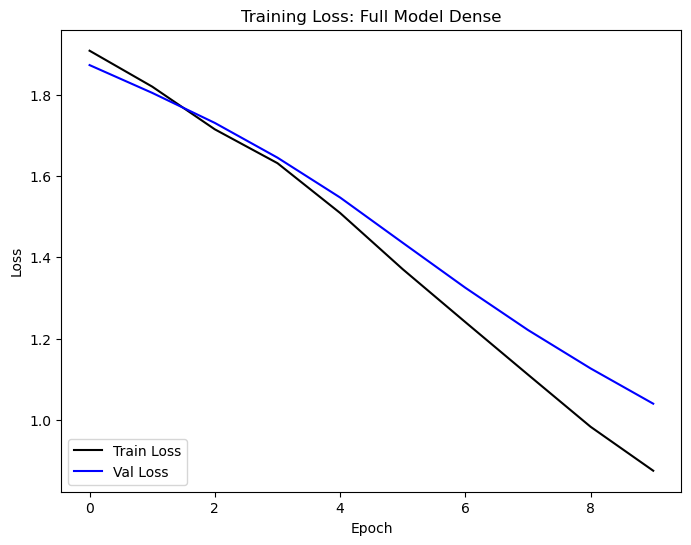

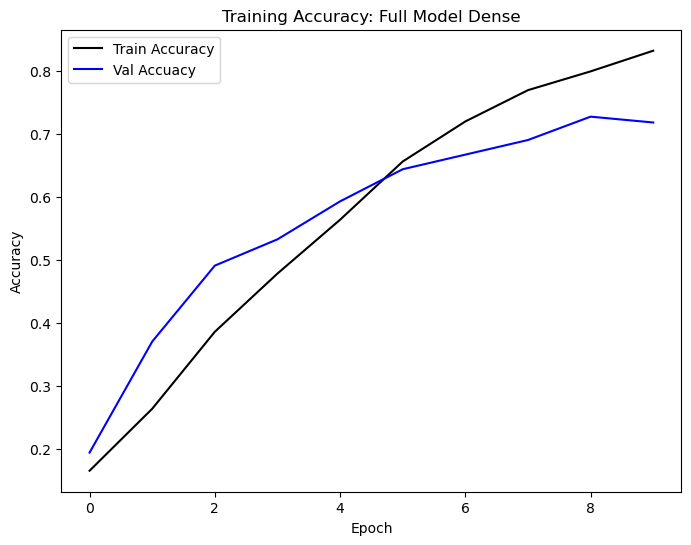

In [12]:
# Asserting the figure directories
fig_dir = os.path.join(os.getcwd(), 'Figures')
# Training Loss Plot File Name 
loss_fn = os.path.join(fig_dir, f'training_loss_full_model_dense.png')
acc_fn = os.path.join(fig_dir, f'training_acc_full_model_dense.png')

# PLotting the model history for pre-training 
plot_history(history_pre, 
             loss_fn, acc_fn, 
             loss_title = f'Training Loss: Full Model Dense', 
             acc_title = f'Training Accuracy: Full Model Dense')

In [13]:
# Making all of the model's layers trainable 
for layer in model.layers: 
    layer.trainable = True 

# Recompiling he model at half the learning rate
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
             )

# Savinf the model at the epoch with the lowest valdiation loss
callback_list = [
       tf.keras.callbacks.ModelCheckpoint(
           filepath= model_fname, 
           verbose=1, save_freq='epoch', 
           monitor='val_loss', save_best_only=True, mode='min'
       )         
]

# Training the model for 10 more epochs for fine-tuning 
history_post = model.fit(x = [vis_train_feats, aud_train_feats], 
                    y = train_tar_oh, 
                    validation_data = ([vis_val_feats, aud_val_feats], val_tar_oh), 
                    shuffle=True,
                    epochs = 10, batch_size=56, 
                    callbacks= callback_list)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.7754 - accuracy: 0.8591
Epoch 1: val_loss improved from inf to 1.00083, saving model to C:\Users\johnd\Documents\MSDS\Capstone\Final\Models\audio_visual_full_model.h5
18/18 [==============================] - 138s 7s/step - loss: 0.7754 - accuracy: 0.8591 - val_loss: 1.0008 - val_accuracy: 0.7083
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.7099 - accuracy: 0.8661
Epoch 2: val_loss improved from 1.00083 to 0.92902, saving model to C:\Users\johnd\Documents\MSDS\Capstone\Final\Models\audio_visual_full_model.h5
18/18 [==============================] - 105s 6s/step - loss: 0.7099 - accuracy: 0.8661 - val_loss: 0.9290 - val_accuracy: 0.7130
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.8681
Epoch 3: val_loss improved from 0.92902 to 0.89844, saving model to C:\Users\johnd\Documents\MSDS\Capstone\Final\Models\audio_visual_full_model.h5
18/18 [==============

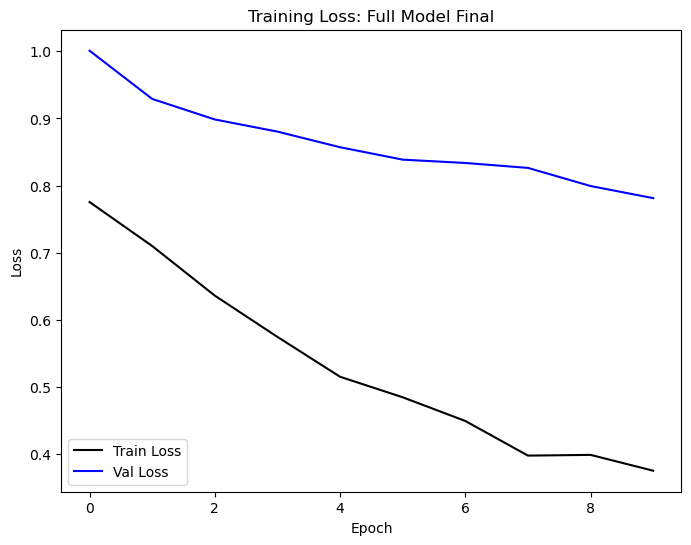

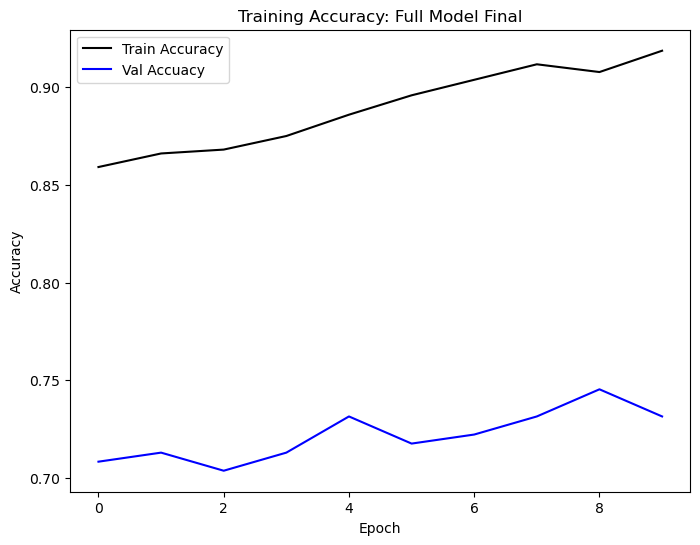

In [14]:
# Training Loss Plot File Name 
loss_fn = os.path.join(fig_dir, f'training_loss_full_model_final.png')
acc_fn = os.path.join(fig_dir, f'training_acc_full_model_final.png')

# Plotting the history of post-training 
plot_history(history_post, 
             loss_fn, acc_fn, 
             loss_title = f'Training Loss: Full Model Final', 
             acc_title = f'Training Accuracy: Full Model Final')

In [15]:
# Reloading the best model 
best_model = tf.keras.models.load_model(filepath = model_fname)
# Gathering Test Set Predictions
test_preds = best_model.predict([vis_test_feats, aud_test_feats])
# Converting Predictions to categories 
test_preds = np.argmax(test_preds, axis=1, keepdims = True)
test_preds = tf.keras.utils.to_categorical(test_preds).astype(np.int64).tolist()
test_preds = [inv_label(pred) for pred in test_preds]
true = [inv_label(tar) for tar in list(test_tar_oh.numpy())]

7/7 [==============================] - 9s 999ms/step


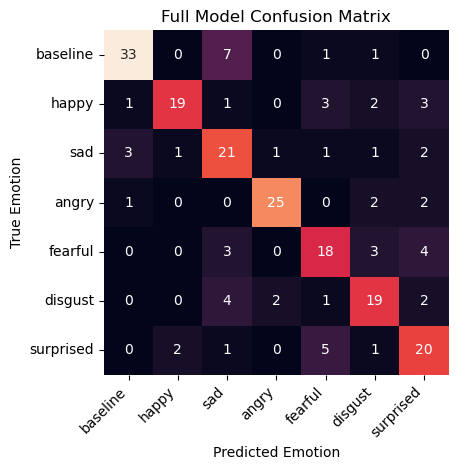

In [16]:
# Test Confusion Matrix File Name
cm_fname = os.path.join(fig_dir, f'test_full_model_cm.png')

# Setting category labels for the cm plot
categories = ['baseline', 'happy', 'sad', 'angry',
             'fearful', 'disgust','surprised']

# Calculating the Confusion Matrix 
cm = confusion_matrix(y_true = true, y_pred = test_preds, labels=categories)

# Plotting and saving the confusion matrix 
fig, ax = plt.subplots()
plt.title(f'Full Model Confusion Matrix')
sns.heatmap(cm, ax=ax, annot=True, cbar=False, square=True)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_yticklabels(categories, rotation=0, ha='right')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.tight_layout()
plt.savefig(cm_fname)
plt.show()

In [17]:
# Showing Classification Report for Test Set
from sklearn.metrics import recall_score
print(f'Testing Set Accuracy: {accuracy_score(true, test_preds)}')
print(f'Testing Set Recall: {recall_score(true, test_preds, average="weighted")}')
print(classification_report(y_true=true, y_pred=test_preds))

Testing Set Accuracy: 0.7175925925925926
Testing Set Recall: 0.7175925925925926
              precision    recall  f1-score   support

       angry       0.89      0.83      0.86        30
    baseline       0.87      0.79      0.82        42
     disgust       0.66      0.68      0.67        28
     fearful       0.62      0.64      0.63        28
       happy       0.86      0.66      0.75        29
         sad       0.57      0.70      0.63        30
   surprised       0.61      0.69      0.65        29

    accuracy                           0.72       216
   macro avg       0.72      0.71      0.71       216
weighted avg       0.73      0.72      0.72       216



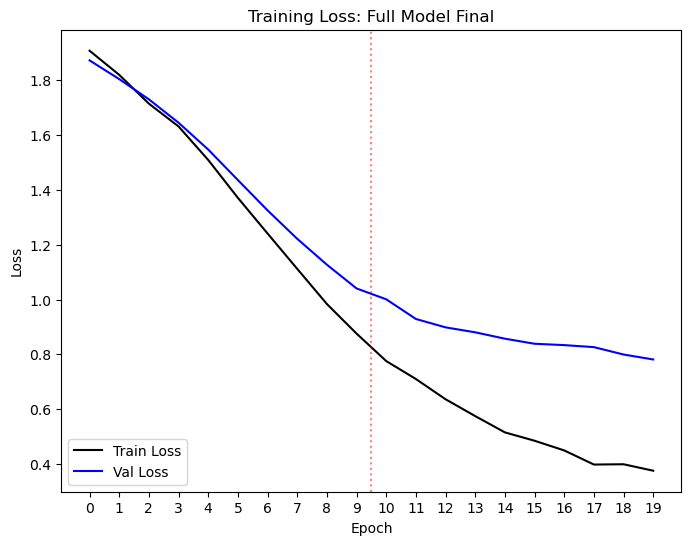

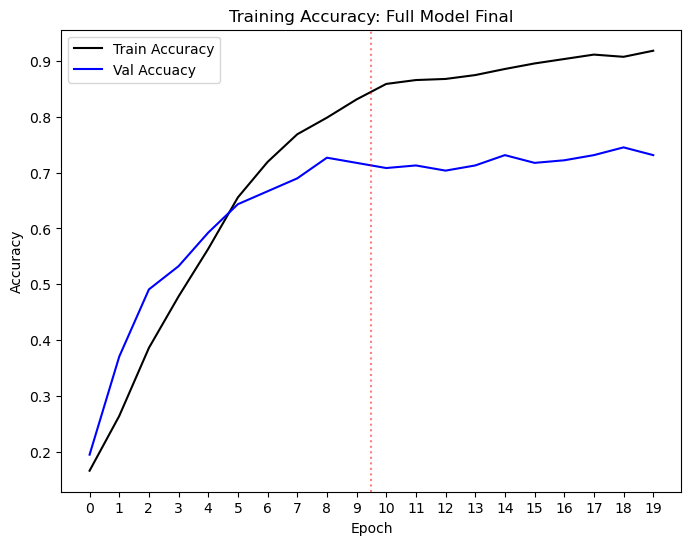

In [18]:
# Training Loss Plot File Name 
loss_fn = os.path.join(fig_dir, f'training_loss_full_model_final.png')
acc_fn = os.path.join(fig_dir, f'training_acc_full_model_final.png')
# Setting the plot titles
loss_title = f'Training Loss: Full Model Final' 
acc_title = f'Training Accuracy: Full Model Final'



# Plot training loss
plt.figure(figsize=(8, 6))

plt.plot(history_pre.history['loss'] + history_post.history['loss'], color='black')
plt.plot(history_pre.history['val_loss'] + history_post.history['val_loss'], color='blue')
plt.axvline(x=9.5, color='red', alpha=0.5, ls=':')
plt.title(loss_title)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, 20, 1))
plt.legend(['Train Loss', 'Val Loss'], loc='lower left')
plt.savefig(loss_fn)
plt.show()

# Plot training Accuracy
plt.figure(figsize=(8, 6))

plt.plot(history_pre.history['accuracy'] + history_post.history['accuracy'], color='black')
plt.plot(history_pre.history['val_accuracy'] + history_post.history['val_accuracy'], color='blue')
plt.axvline(x=9.5, color='red', alpha=0.5, ls=':')
plt.xticks(range(0, 20, 1))
plt.title(acc_title)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Val Accuacy'], loc='upper left')
plt.savefig(acc_fn)
plt.show() 

In [19]:
### Separating Test set into High and Low Intensity Partitions 
test_meta = vis_metadata[vis_metadata['partition'] == 'test']
# Getting Indicies of High and Low Test Set Observations
low_int_fns = test_meta[test_meta['intensity'] == 1].fname.tolist()
high_int_fns = test_meta[test_meta['intensity'] == 2].fname.tolist()
low_int_idxs = [vis_test_fn.index(fn) for fn in low_int_fns] 
high_int_idxs = [vis_test_fn.index(fn) for fn in high_int_fns] 
# Splitting the test set based on intensity (from indicies)
lo_test_tar, lo_test_vis, lo_test_aud = [tf.gather(tens, indices = low_int_idxs) for tens in [test_tar_oh, vis_test_feats, aud_test_feats]]
hi_test_tar, hi_test_vis, hi_test_aud = [tf.gather(tens, indices = high_int_idxs) for tens in [test_tar_oh, vis_test_feats, aud_test_feats]]

4/4 [==============================] - 5s 813ms/step


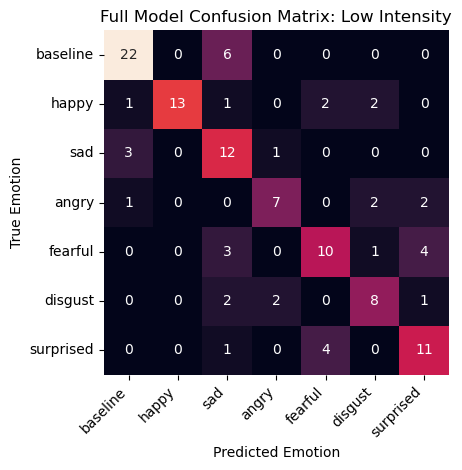

Testing Set Accuracy: 0.680327868852459
Testing Set Recall: 0.680327868852459
              precision    recall  f1-score   support

       angry       0.70      0.58      0.64        12
    baseline       0.81      0.79      0.80        28
     disgust       0.62      0.62      0.62        13
     fearful       0.62      0.56      0.59        18
       happy       1.00      0.68      0.81        19
         sad       0.48      0.75      0.59        16
   surprised       0.61      0.69      0.65        16

    accuracy                           0.68       122
   macro avg       0.69      0.67      0.67       122
weighted avg       0.71      0.68      0.69       122



In [20]:
# Reloading the best model 
best_model = tf.keras.models.load_model(filepath = model_fname)
# Gathering Test Set Predictions
lo_preds = best_model.predict([lo_test_vis, lo_test_aud])
# One-Hot Encoding Low Intensity Test Observations
lo_preds =  np.argmax(lo_preds, axis=1, keepdims = True)
lo_preds = tf.keras.utils.to_categorical(lo_preds).astype(np.int64).tolist()
lo_preds = [inv_label(pred) for pred in lo_preds]
lo_true = [inv_label(tar) for tar in list(lo_test_tar.numpy())]

# Low Intensity Test Confusion Matrix File Name
cm_fname = os.path.join(fig_dir, f'test_full_model_low_intensity_cm.png')

### Low Intensity Confusion Matrix
categories = ['baseline', 'happy', 'sad', 'angry',
             'fearful', 'disgust','surprised']
cm = confusion_matrix(y_true = lo_true, y_pred = lo_preds, labels=categories)
fig, ax = plt.subplots()
plt.title(f'Full Model Confusion Matrix: Low Intensity')
sns.heatmap(cm, ax=ax, annot=True, cbar=False, square=True)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_yticklabels(categories, rotation=0, ha='right')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.tight_layout()
plt.savefig(cm_fname)
plt.show()

### Showing Classification Report for Low Intensity Test Set
from sklearn.metrics import recall_score
print(f'Testing Set Accuracy: {accuracy_score(lo_true, lo_preds)}')
print(f'Testing Set Recall: {recall_score(lo_true, lo_preds, average="weighted")}')
print(classification_report(y_true=lo_true, y_pred=lo_preds))

3/3 [==============================] - 2s 758ms/step


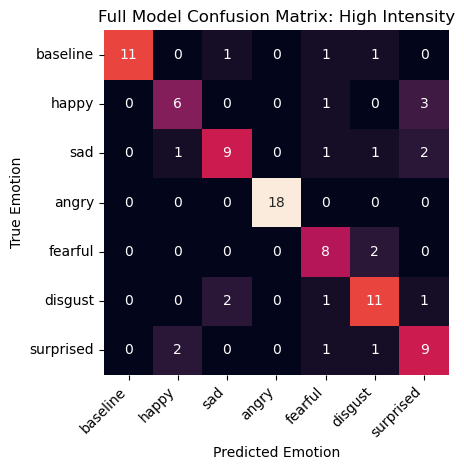

Testing Set Accuracy: 0.7659574468085106
Testing Set Recall: 0.7659574468085106
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        18
    baseline       1.00      0.79      0.88        14
     disgust       0.69      0.73      0.71        15
     fearful       0.62      0.80      0.70        10
       happy       0.67      0.60      0.63        10
         sad       0.75      0.64      0.69        14
   surprised       0.60      0.69      0.64        13

    accuracy                           0.77        94
   macro avg       0.76      0.75      0.75        94
weighted avg       0.78      0.77      0.77        94



In [21]:
### One-Hot Encoding High Intensity Test Set Observations
hi_preds = best_model.predict([hi_test_vis, hi_test_aud])
hi_preds =  np.argmax(hi_preds, axis=1, keepdims = True)
hi_preds = tf.keras.utils.to_categorical(hi_preds).astype(np.int64).tolist()
hi_preds = [inv_label(pred) for pred in hi_preds]
hi_true = [inv_label(tar) for tar in list(hi_test_tar.numpy())]

# Test Confusion Matrix File Name
cm_fname = os.path.join(fig_dir, f'test_full_model_high_intensity_cm.png')


### High Intensity COnfusion Matrix 
categories = ['baseline', 'happy', 'sad', 'angry',
             'fearful', 'disgust','surprised']
cm = confusion_matrix(y_true = hi_true, y_pred = hi_preds, labels=categories)
fig, ax = plt.subplots()
plt.title(f'Full Model Confusion Matrix: High Intensity')
sns.heatmap(cm, ax=ax, annot=True, cbar=False, square=True)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_yticklabels(categories, rotation=0, ha='right')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.tight_layout()
plt.savefig(cm_fname)
plt.show()

# Showing Classification Report for Test Set
from sklearn.metrics import recall_score
print(f'Testing Set Accuracy: {accuracy_score(hi_true, hi_preds)}')
print(f'Testing Set Recall: {recall_score(hi_true, hi_preds, average="weighted")}')
print(classification_report(y_true=hi_true, y_pred=hi_preds))